In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bankpromotion/bank-additional.csv
/kaggle/input/bankpromotion/bank-additional-full.csv


In [71]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold,train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score,f1_score
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [72]:

data_1=pd.read_csv("/kaggle/input/bankpromotion/bank-additional-full.csv",sep=";")
data_2=pd.read_csv("/kaggle/input/bankpromotion/bank-additional.csv",sep=";")
data=pd.concat([data_1,data_2],axis=0)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Text(0.5, 1.0, 'Variable Correlation')

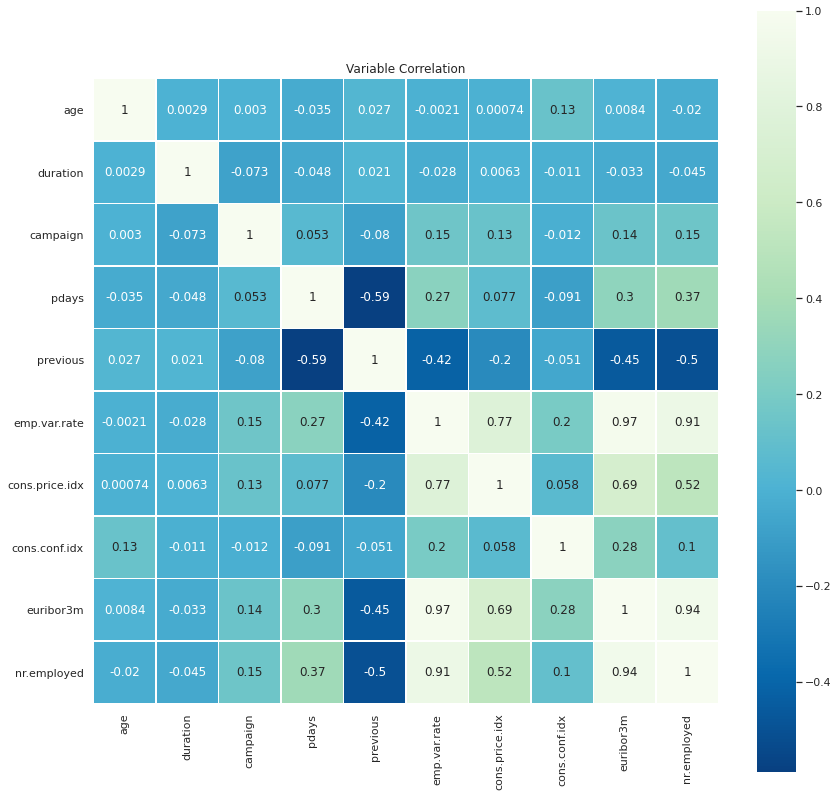

In [73]:
#Correlation Plot
plt.figure(figsize=(14,14))
sns.set(font_scale=1)
sns.heatmap(data.corr(),cmap='GnBu_r',annot=True, square = True ,linewidths=.5);
plt.title('Variable Correlation')

In [74]:
#To avoid mulicorinality drop the higly correltaed column
data = data.drop(["emp.var.rate","nr.employed"],axis=1)
data.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,93.994,-36.4,4.857,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,93.994,-36.4,4.857,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,93.994,-36.4,4.857,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,93.994,-36.4,4.857,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,93.994,-36.4,4.857,no


In [75]:
#label encoding

jobDummies = pd.get_dummies(data['job'], prefix = 'job')
maritalDummies = pd.get_dummies(data['marital'], prefix = 'marital')
educationDummies = pd.get_dummies(data['education'], prefix = 'education')
defaultDummies = pd.get_dummies(data['default'], prefix = 'default')
housingDummies = pd.get_dummies(data['housing'], prefix = 'housing')
loanDummies = pd.get_dummies(data['loan'], prefix = 'loan')
contactDummies = pd.get_dummies(data['contact'], prefix = 'contact')
poutcomeDummies = pd.get_dummies(data['poutcome'], prefix = 'poutcome')
data['month']=data['month'].astype('category')
data['day_of_week']=data['day_of_week'].astype('category')
data['y']=data['y'].astype('category')

# Assigning numerical values and storing in another column
data['month'] = data['month'].cat.codes
data['day_of_week'] = data['day_of_week'].cat.codes
data['y'] = data['y'].cat.codes

data['y'].dtype

dtype('int8')

In [76]:
data["age"]=data["age"].astype("int")
data["duration"]=data["duration"].astype("int")
data["pdays"]=data["pdays"].astype("int")
data["previous"]=data["previous"].astype("int")
data["campaign"]=data["campaign"].astype("int")
data_int=data.select_dtypes(include=['int','float64','bool'])
#data_int
bank_df=pd.concat([data_int,jobDummies,maritalDummies,educationDummies,defaultDummies,housingDummies,loanDummies
                  ,contactDummies,poutcomeDummies,data['month'],data['day_of_week'],data['y']],axis=1)
bank_df.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,job_admin.,job_blue-collar,...,loan_unknown,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,month,day_of_week,y
0,56,261,1,999,0,93.994,-36.4,4.857,0,0,...,0,0,0,1,0,1,0,6,1,0
1,57,149,1,999,0,93.994,-36.4,4.857,0,0,...,0,0,0,1,0,1,0,6,1,0
2,37,226,1,999,0,93.994,-36.4,4.857,0,0,...,0,0,0,1,0,1,0,6,1,0
3,40,151,1,999,0,93.994,-36.4,4.857,1,0,...,0,0,0,1,0,1,0,6,1,0
4,56,307,1,999,0,93.994,-36.4,4.857,0,0,...,0,1,0,1,0,1,0,6,1,0


49


/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:3

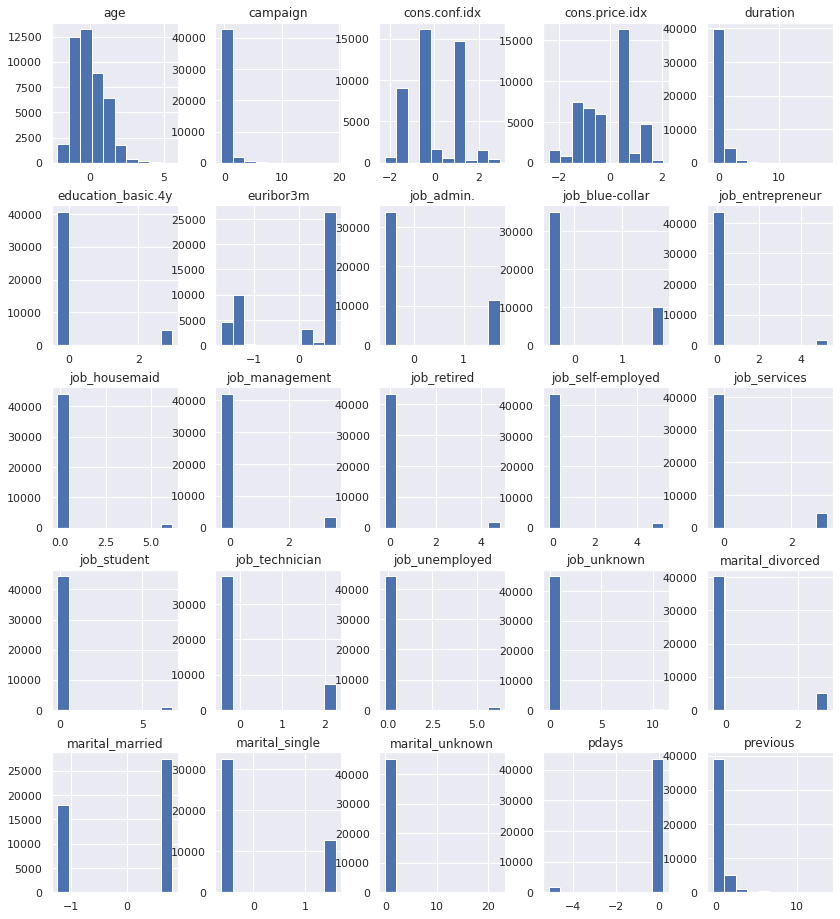

In [77]:
#checking variable distribution
print(len(bank_df.columns))
df_test = bank_df.iloc[:,0:25]
for index in range(25):
    df_test.iloc[:,index] = (df_test.iloc[:,index]-df_test.iloc[:,index].mean()) / df_test.iloc[:,index].std();
df_test.hist(figsize= (14,16));

In [78]:
#Predictors count
bank_df.groupby('y').size()

y
0    40216
1     5091
dtype: int64

In [79]:
#Total features after one-hot-encoding
features = bank_df.columns
len(features)

49

In [80]:
#Variables and Output
y=np.array(bank_df["y"])
X=np.array(bank_df.iloc[:,0:48])


In [81]:
#Partition of Dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [82]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(36245, 2)


In [83]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

In [84]:
# define the model
#get number of columns in training data
n_cols=X_train.shape[1]

# define model 2 layers
model = Sequential()
model.add(Dense(100, input_dim=n_cols, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [85]:
epochs= 300
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)


Train on 28996 samples, validate on 7249 samples
Epoch 1/300
28996/28996 [==============================] - 1s 21us/step - loss: 0.2860 - accuracy: 0.8834 - val_loss: 0.2248 - val_accuracy: 0.9038
Epoch 2/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.2081 - accuracy: 0.9102 - val_loss: 0.2101 - val_accuracy: 0.9082
Epoch 3/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1976 - accuracy: 0.9123 - val_loss: 0.2038 - val_accuracy: 0.9101
Epoch 4/300
28996/28996 [==============================] - 0s 17us/step - loss: 0.1917 - accuracy: 0.9144 - val_loss: 0.1999 - val_accuracy: 0.9101
Epoch 5/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1878 - accuracy: 0.9160 - val_loss: 0.1984 - val_accuracy: 0.9100
Epoch 6/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1849 - accuracy: 0.9161 - val_loss: 0.1992 - val_accuracy: 0.9098
Epoch 7/300
28996/28996 [==============================] - 0s 1

Epoch 56/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1442 - accuracy: 0.9372 - val_loss: 0.2148 - val_accuracy: 0.9082
Epoch 57/300
28996/28996 [==============================] - 0s 17us/step - loss: 0.1436 - accuracy: 0.9381 - val_loss: 0.2152 - val_accuracy: 0.9087
Epoch 58/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1428 - accuracy: 0.9381 - val_loss: 0.2193 - val_accuracy: 0.9080
Epoch 59/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1414 - accuracy: 0.9400 - val_loss: 0.2170 - val_accuracy: 0.9051
Epoch 60/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1421 - accuracy: 0.9391 - val_loss: 0.2185 - val_accuracy: 0.9074
Epoch 61/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1409 - accuracy: 0.9398 - val_loss: 0.2189 - val_accuracy: 0.9073
Epoch 62/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1399 - accuracy: 0.9400

Epoch 111/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1181 - accuracy: 0.9513 - val_loss: 0.2505 - val_accuracy: 0.9041
Epoch 112/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1173 - accuracy: 0.9503 - val_loss: 0.2541 - val_accuracy: 0.9054
Epoch 113/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1168 - accuracy: 0.9516 - val_loss: 0.2514 - val_accuracy: 0.9073
Epoch 114/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1170 - accuracy: 0.9523 - val_loss: 0.2521 - val_accuracy: 0.9075
Epoch 115/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1159 - accuracy: 0.9527 - val_loss: 0.2591 - val_accuracy: 0.9055
Epoch 116/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1163 - accuracy: 0.9521 - val_loss: 0.2577 - val_accuracy: 0.9038
Epoch 117/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1151 - accuracy:

28996/28996 [==============================] - 0s 16us/step - loss: 0.1031 - accuracy: 0.9587 - val_loss: 0.2899 - val_accuracy: 0.9004
Epoch 166/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1027 - accuracy: 0.9582 - val_loss: 0.2869 - val_accuracy: 0.9013
Epoch 167/300
28996/28996 [==============================] - 0s 17us/step - loss: 0.1016 - accuracy: 0.9593 - val_loss: 0.2894 - val_accuracy: 0.9033
Epoch 168/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1014 - accuracy: 0.9589 - val_loss: 0.2897 - val_accuracy: 0.9020
Epoch 169/300
28996/28996 [==============================] - 1s 17us/step - loss: 0.1013 - accuracy: 0.9589 - val_loss: 0.2893 - val_accuracy: 0.9013
Epoch 170/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.1018 - accuracy: 0.9591 - val_loss: 0.2874 - val_accuracy: 0.9038
Epoch 171/300
28996/28996 [==============================] - 0s 17us/step - loss: 0.1006 - accuracy: 0.9589 - val_

Epoch 220/300
28996/28996 [==============================] - 0s 17us/step - loss: 0.0926 - accuracy: 0.9627 - val_loss: 0.3235 - val_accuracy: 0.9019
Epoch 221/300
28996/28996 [==============================] - 1s 18us/step - loss: 0.0922 - accuracy: 0.9624 - val_loss: 0.3315 - val_accuracy: 0.9026
Epoch 222/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.0922 - accuracy: 0.9635 - val_loss: 0.3272 - val_accuracy: 0.9033
Epoch 223/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.0905 - accuracy: 0.9628 - val_loss: 0.3279 - val_accuracy: 0.8986
Epoch 224/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.0920 - accuracy: 0.9627 - val_loss: 0.3247 - val_accuracy: 0.8994
Epoch 225/300
28996/28996 [==============================] - 0s 17us/step - loss: 0.0918 - accuracy: 0.9635 - val_loss: 0.3275 - val_accuracy: 0.9023
Epoch 226/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.0912 - accuracy:

28996/28996 [==============================] - 0s 16us/step - loss: 0.0845 - accuracy: 0.9660 - val_loss: 0.3574 - val_accuracy: 0.8994
Epoch 275/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.0849 - accuracy: 0.9666 - val_loss: 0.3592 - val_accuracy: 0.9025
Epoch 276/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.0839 - accuracy: 0.9659 - val_loss: 0.3636 - val_accuracy: 0.9003
Epoch 277/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.0851 - accuracy: 0.9663 - val_loss: 0.3604 - val_accuracy: 0.8975
Epoch 278/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.0835 - accuracy: 0.9669 - val_loss: 0.3662 - val_accuracy: 0.9012
Epoch 279/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.0845 - accuracy: 0.9662 - val_loss: 0.3585 - val_accuracy: 0.9001
Epoch 280/300
28996/28996 [==============================] - 0s 16us/step - loss: 0.0840 - accuracy: 0.9654 - val_

In [86]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

9062/9062 [==============================] - 0s 13us/step


In [87]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.902339
Precision: 0.575171
Recall: 0.496559
F1 score: 0.532982


In [88]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


ROC AUC: 0.907739


In [89]:
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

[[7672  373]
 [ 512  505]]


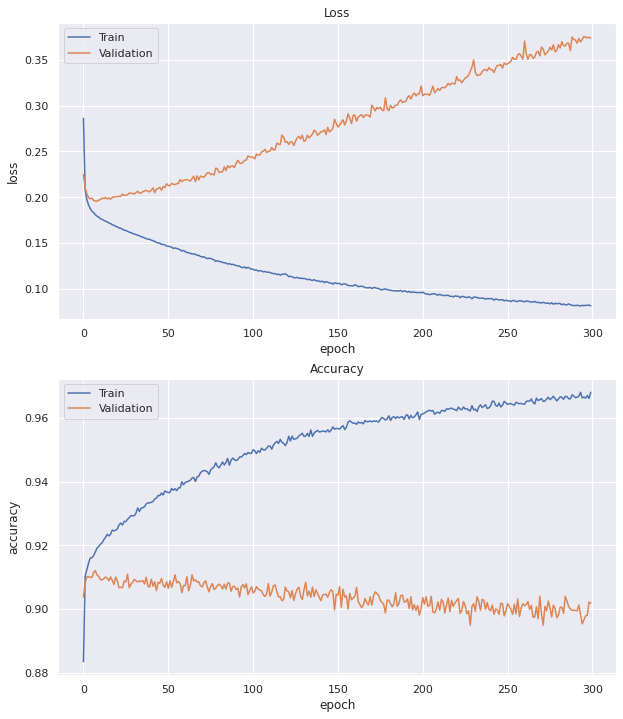

In [90]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [91]:
#Add Additional Layer

In [92]:
# define the model
#get number of columns in training data
n_cols=X_train.shape[1]

# define model 2 layers
model = Sequential()
model.add(Dense(100, input_dim=n_cols, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [93]:
epochs= 200
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=32, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)


Train on 28996 samples, validate on 7249 samples
Epoch 1/200
28996/28996 [==============================] - 2s 54us/step - loss: 0.2195 - accuracy: 0.9045 - val_loss: 0.1979 - val_accuracy: 0.9079
Epoch 2/200
28996/28996 [==============================] - 1s 51us/step - loss: 0.1913 - accuracy: 0.9140 - val_loss: 0.1962 - val_accuracy: 0.9092
Epoch 3/200
28996/28996 [==============================] - 1s 49us/step - loss: 0.1856 - accuracy: 0.9166 - val_loss: 0.1969 - val_accuracy: 0.9090
Epoch 4/200
28996/28996 [==============================] - 1s 48us/step - loss: 0.1819 - accuracy: 0.9172 - val_loss: 0.1956 - val_accuracy: 0.9099
Epoch 5/200
28996/28996 [==============================] - 1s 49us/step - loss: 0.1781 - accuracy: 0.9191 - val_loss: 0.1973 - val_accuracy: 0.9097
Epoch 6/200
28996/28996 [==============================] - 1s 49us/step - loss: 0.1745 - accuracy: 0.9199 - val_loss: 0.1967 - val_accuracy: 0.9090
Epoch 7/200
28996/28996 [==============================] - 1s 4

Epoch 56/200
28996/28996 [==============================] - 1s 49us/step - loss: 0.0542 - accuracy: 0.9785 - val_loss: 0.4410 - val_accuracy: 0.9018
Epoch 57/200
28996/28996 [==============================] - 1s 50us/step - loss: 0.0533 - accuracy: 0.9790 - val_loss: 0.4499 - val_accuracy: 0.9044
Epoch 58/200
28996/28996 [==============================] - 1s 51us/step - loss: 0.0548 - accuracy: 0.9780 - val_loss: 0.4689 - val_accuracy: 0.9074
Epoch 59/200
28996/28996 [==============================] - 1s 49us/step - loss: 0.0519 - accuracy: 0.9797 - val_loss: 0.4717 - val_accuracy: 0.9029
Epoch 60/200
28996/28996 [==============================] - 1s 48us/step - loss: 0.0508 - accuracy: 0.9793 - val_loss: 0.4836 - val_accuracy: 0.9007
Epoch 61/200
28996/28996 [==============================] - 1s 49us/step - loss: 0.0505 - accuracy: 0.9808 - val_loss: 0.5015 - val_accuracy: 0.9056
Epoch 62/200
28996/28996 [==============================] - 1s 48us/step - loss: 0.0485 - accuracy: 0.9805

Epoch 111/200
28996/28996 [==============================] - 1s 47us/step - loss: 0.0306 - accuracy: 0.9894 - val_loss: 0.8042 - val_accuracy: 0.8972
Epoch 112/200
28996/28996 [==============================] - 1s 48us/step - loss: 0.0283 - accuracy: 0.9895 - val_loss: 0.8221 - val_accuracy: 0.9044
Epoch 113/200
28996/28996 [==============================] - 1s 47us/step - loss: 0.0269 - accuracy: 0.9898 - val_loss: 0.8249 - val_accuracy: 0.9018
Epoch 114/200
28996/28996 [==============================] - 1s 48us/step - loss: 0.0306 - accuracy: 0.9892 - val_loss: 0.8020 - val_accuracy: 0.9022
Epoch 115/200
28996/28996 [==============================] - 1s 47us/step - loss: 0.0299 - accuracy: 0.9898 - val_loss: 0.8216 - val_accuracy: 0.9047
Epoch 116/200
28996/28996 [==============================] - 1s 48us/step - loss: 0.0247 - accuracy: 0.9917 - val_loss: 0.8087 - val_accuracy: 0.9015
Epoch 117/200
28996/28996 [==============================] - 1s 47us/step - loss: 0.0283 - accuracy:

28996/28996 [==============================] - 1s 47us/step - loss: 0.0225 - accuracy: 0.9932 - val_loss: 1.0592 - val_accuracy: 0.9041
Epoch 166/200
28996/28996 [==============================] - 1s 47us/step - loss: 0.0244 - accuracy: 0.9923 - val_loss: 1.0325 - val_accuracy: 0.9003
Epoch 167/200
28996/28996 [==============================] - 1s 49us/step - loss: 0.0193 - accuracy: 0.9933 - val_loss: 1.0390 - val_accuracy: 0.9066
Epoch 168/200
28996/28996 [==============================] - 2s 53us/step - loss: 0.0219 - accuracy: 0.9931 - val_loss: 1.0373 - val_accuracy: 0.8989
Epoch 169/200
28996/28996 [==============================] - 1s 51us/step - loss: 0.0207 - accuracy: 0.9926 - val_loss: 1.1020 - val_accuracy: 0.9023
Epoch 170/200
28996/28996 [==============================] - 2s 52us/step - loss: 0.0192 - accuracy: 0.9940 - val_loss: 1.0796 - val_accuracy: 0.9047
Epoch 171/200
28996/28996 [==============================] - 2s 52us/step - loss: 0.0192 - accuracy: 0.9946 - val_

In [94]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

9062/9062 [==============================] - 0s 11us/step


In [95]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.904326
Precision: 0.577801
Recall: 0.547689
F1 score: 0.562342


In [96]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


ROC AUC: 0.900382


In [97]:
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

[[7638  407]
 [ 460  557]]


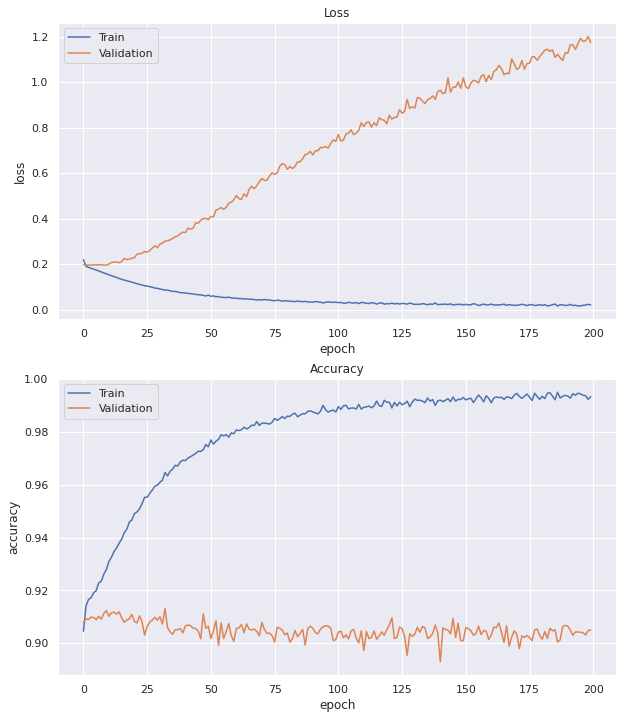

In [98]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [99]:
#3rd Trial

In [100]:
#Partition of Dataset
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)



(45307,)


In [127]:
# define 10-fold cross validation test harness
seed=7
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

[    0     1     2 ... 45303 45305 45306]
[    0     1     2 ... 45304 45305 45306]
[    0     1     2 ... 45303 45304 45305]
[    0     2     3 ... 45304 45305 45306]
[    0     1     2 ... 45304 45305 45306]
[    0     1     2 ... 45304 45305 45306]
[    0     1     2 ... 45304 45305 45306]
[    1     2     3 ... 45304 45305 45306]
[    0     1     2 ... 45304 45305 45306]
[    0     1     3 ... 45303 45304 45306]


In [128]:
# define the model
#get number of columns in training data
n_cols=X_train.shape[1]

# define model 2 layers
model = Sequential()
model.add(Dense(100, input_dim=n_cols, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [129]:
epochs= 100
start=time.time()
cvscores_test = []
cvscores_train = []
for train, test in kfold.split(X, y):
    y_true_train = to_categorical(y[train])
    y_true_test = to_categorical(y[test])


    #fit model
    hist=model.fit(X[train], y_true_train, epochs=epochs,batch_size=32, verbose=1)
    # evaluate the model
    scores_test = model.evaluate(X[test], y_true_test, verbose=0)
    #print("Test:')
    print("Test - ", model.metrics_names[1],"-", scores_test[1]*100)
    cvscores_test.append(scores_test[1] * 100)
    
    scores_train = model.evaluate(X[train], y_true_train, verbose=0)
    #print('Train:')
    print("Train - ",model.metrics_names[1] ,"-",scores_train[1]*100)
    cvscores_train.append(scores_train[1] * 10)



Epoch 1/100
36245/36245 [==============================] - 2s 47us/step - loss: 0.6634 - accuracy: 0.8853
Epoch 2/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.3165 - accuracy: 0.8934
Epoch 3/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.2827 - accuracy: 0.8985
Epoch 4/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.2615 - accuracy: 0.8988
Epoch 5/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.2605 - accuracy: 0.8987
Epoch 6/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.2331 - accuracy: 0.9025
Epoch 7/100
36245/36245 [==============================] - 2s 43us/step - loss: 0.2278 - accuracy: 0.9027
Epoch 8/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.2188 - accuracy: 0.9045
Epoch 9/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.2162 - accuracy: 0.9042
Epoch 10/100
36245/36245 [====================

36245/36245 [==============================] - 2s 42us/step - loss: 0.1909 - accuracy: 0.9121
Epoch 78/100
36245/36245 [==============================] - 2s 43us/step - loss: 0.1916 - accuracy: 0.9117
Epoch 79/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.1912 - accuracy: 0.9121
Epoch 80/100
36245/36245 [==============================] - 2s 43us/step - loss: 0.1915 - accuracy: 0.9121
Epoch 81/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.1912 - accuracy: 0.9121
Epoch 82/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.1904 - accuracy: 0.9130
Epoch 83/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.1911 - accuracy: 0.9115
Epoch 84/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.1910 - accuracy: 0.9122
Epoch 85/100
36245/36245 [==============================] - 2s 43us/step - loss: 0.1907 - accuracy: 0.9118
Epoch 86/100
36245/36245 [========================

36245/36245 [==============================] - 2s 41us/step - loss: 0.1871 - accuracy: 0.9152
Epoch 54/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.1869 - accuracy: 0.9152
Epoch 55/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.1868 - accuracy: 0.9148
Epoch 56/100
36245/36245 [==============================] - 1s 41us/step - loss: 0.1880 - accuracy: 0.9153
Epoch 57/100
36245/36245 [==============================] - 2s 43us/step - loss: 0.1868 - accuracy: 0.9152
Epoch 58/100
36245/36245 [==============================] - 2s 42us/step - loss: 0.1877 - accuracy: 0.9153
Epoch 59/100
36245/36245 [==============================] - 1s 41us/step - loss: 0.1874 - accuracy: 0.9148
Epoch 60/100
36245/36245 [==============================] - 1s 41us/step - loss: 0.1872 - accuracy: 0.9155
Epoch 61/100
36245/36245 [==============================] - 1s 41us/step - loss: 0.1864 - accuracy: 0.9146
Epoch 62/100
36245/36245 [========================

36246/36246 [==============================] - 2s 42us/step - loss: 0.1870 - accuracy: 0.9140
Epoch 29/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1871 - accuracy: 0.9144
Epoch 30/100
36246/36246 [==============================] - 2s 42us/step - loss: 0.1870 - accuracy: 0.9148
Epoch 31/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1862 - accuracy: 0.9150
Epoch 32/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1872 - accuracy: 0.9146
Epoch 33/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1901 - accuracy: 0.9139
Epoch 34/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1868 - accuracy: 0.9153
Epoch 35/100
36246/36246 [==============================] - 1s 40us/step - loss: 0.1864 - accuracy: 0.9144
Epoch 36/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1871 - accuracy: 0.9139
Epoch 37/100
36246/36246 [========================

36246/36246 [==============================] - 1s 40us/step - loss: 0.1861 - accuracy: 0.9133
Epoch 5/100
36246/36246 [==============================] - 1s 40us/step - loss: 0.1852 - accuracy: 0.9152
Epoch 6/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1854 - accuracy: 0.9147
Epoch 7/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1854 - accuracy: 0.9151
Epoch 8/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1849 - accuracy: 0.9142
Epoch 9/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1856 - accuracy: 0.9155
Epoch 10/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1854 - accuracy: 0.9149
Epoch 11/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1850 - accuracy: 0.9145
Epoch 12/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1853 - accuracy: 0.9147
Epoch 13/100
36246/36246 [=============================

36246/36246 [==============================] - 1s 41us/step - loss: 0.1788 - accuracy: 0.9163
Epoch 81/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1801 - accuracy: 0.9159
Epoch 82/100
36246/36246 [==============================] - 2s 42us/step - loss: 0.1785 - accuracy: 0.9167
Epoch 83/100
36246/36246 [==============================] - 2s 42us/step - loss: 0.1787 - accuracy: 0.9169
Epoch 84/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1786 - accuracy: 0.9174
Epoch 85/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1795 - accuracy: 0.9159
Epoch 86/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1796 - accuracy: 0.9162
Epoch 87/100
36246/36246 [==============================] - 1s 40us/step - loss: 0.1785 - accuracy: 0.9166
Epoch 88/100
36246/36246 [==============================] - 1s 40us/step - loss: 0.1788 - accuracy: 0.9173
Epoch 89/100
36246/36246 [========================

36246/36246 [==============================] - 1s 41us/step - loss: 0.1737 - accuracy: 0.9186
Epoch 57/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1737 - accuracy: 0.9178
Epoch 58/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1736 - accuracy: 0.9176
Epoch 59/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1734 - accuracy: 0.9181
Epoch 60/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1739 - accuracy: 0.9178
Epoch 61/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1730 - accuracy: 0.9171
Epoch 62/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1728 - accuracy: 0.9187
Epoch 63/100
36246/36246 [==============================] - 2s 42us/step - loss: 0.1728 - accuracy: 0.9184
Epoch 64/100
36246/36246 [==============================] - 1s 41us/step - loss: 0.1729 - accuracy: 0.9183
Epoch 65/100
36246/36246 [========================

NameError: name 'numpy' is not defined

In [130]:
print("Test - ",np.mean(cvscores_test),"-",np.std(cvscores_test))
#print("Train:")
print("Train - ",np.mean(cvscores_train),"-",np.std(cvscores_train))
end=time.time()
print("Elapsed Time: ", end-start)


Test -  nan - nan
Train -  9.157387256622314 - 0.023268147352291404
Elapsed Time:  892.7238471508026


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
